Importing the necessary libraries

In [7]:
import numpy as np
import torch.nn as nn # type: ignore
import torch.nn.functional as F # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
import glob
import cv2 # type: ignore
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

Reading the Images

In [8]:
tumor = [] #brain with a tumor
healthybrain = [] #brain with no tumor
for f in glob.iglob("C:/Users/panig/Desktop/sk/yes/*.jpg"): #reading in images
  img = cv2.imread(f) #reading images using cv2
  img = cv2.resize(img, (128,128)) #resizing images using cv2
  b, g, r = cv2.split(img) #splitting images into respective channels using cv2 (128x128). result in 3 images
  img = cv2.merge([r, g, b])
  tumor.append(img)

for f in glob.iglob("C:/Users/panig/Desktop/sk/no/*.jpg"): #reading in images
  img = cv2.imread(f) #reading images using cv2
  img = cv2.resize(img, (128,128)) #resizing images using cv2
  b,g,r = cv2.split(img) #splitting images into respective channels using cv2 (128x128). result in 3 images
  img = cv2.merge([r, g, b])
  healthybrain.append(img)

In [9]:
healthybrain = np.array(healthybrain)
tumor = np.array(tumor)
#turning both into numpy arrays. .shape shows amnt of images, rows and colums of pixels, and channels of rgb
All = np.concatenate((healthybrain, tumor))

Visualizing MRI Images

In [10]:
def plot_random(healthybrain, tumor, num=5): 
  healthybrain_imgs = healthybrain[np.random.choice(healthybrain.shape[0], num, replace=False)]
  tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

  plt.figure(figsize=(16,9)) #making a plot
  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.title('healthy brain')
    plt.imshow(healthybrain_imgs[i])

  plt.figure(figsize=(16,9))
  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.title('tumor')
    plt.imshow(tumor_imgs[i])

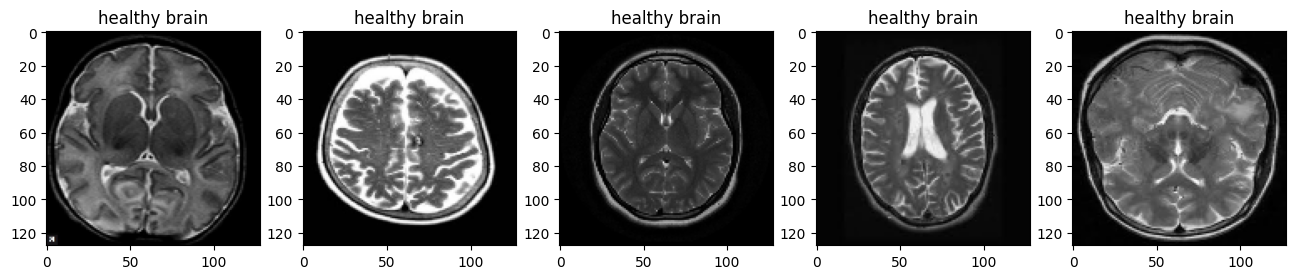

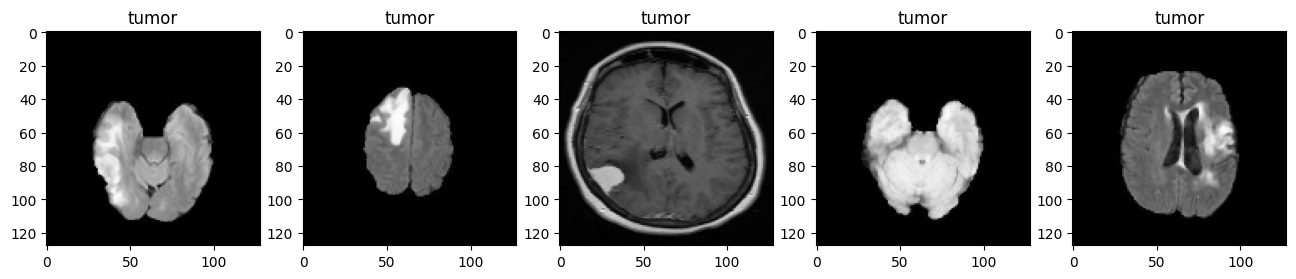

In [11]:
plot_random(healthybrain, tumor)

Creating PyTorch abstract dataset Class and MRI custom dataset class

In [12]:
class Dataset(object): #abstract class representing a dataset

  def __getitem___(self, index):
    raise NotImplementedError

  def __len__(self):
    raise NotImplementedError

  def __add__(self, other):
    return ConcatDataset([self, other]) #needs ConcatDataset to concatenate two objects

In [13]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthybrain = []
        for f in glob.iglob("C:/Users/panig/Desktop/sk/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            tumor.append(img)

        for f in glob.iglob("C:/Users/panig/Desktop/sk/no/*.jpg"):
            img = cv2.imread(f)  # Add this line
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            healthybrain.append(img)

        tumor = np.array(tumor, dtype=np.float32)
        healthybrain = np.array(healthybrain, dtype=np.float32)

        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthybrain_label = np.zeros(healthybrain.shape[0], dtype=np.float32)

        self.images = np.concatenate((tumor, healthybrain), axis=0)
        self.labels = np.concatenate((tumor_label, healthybrain_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images / 255.0



In [14]:
mri_dataset = MRI()
mri_dataset.normalize()

Creating a Dataloader

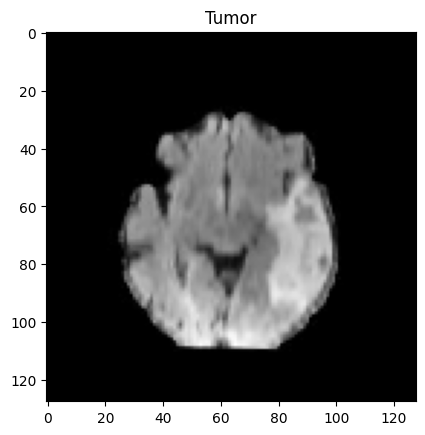

In [15]:
names={0:'Heathy Brain', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    if i == 5:
        break

Creating the actual model

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

Evaluating a New-Born Neural Network

In [17]:

mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu')
model = CNN().to(device)

NameError: name 'torch' is not defined

In [21]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [ ]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [ ]:
accuracy_score(y_true, threshold(outputs))

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()